# <center>*IMPACT PROJECT - GESTAMP*</center> 
## <center>Defect Detection using Machine Learning</center> 
### <center>Hyperparameters Tuning: Random Search using Bayesian Optimizer</center>

<img 
    src="https://www.gestamp.com/getattachment/c8d61c0f-e752-4156-8002-97e21ab43a3f/Imag2-2" width="2400" height="1000" align="center"/>


## <center>Table of Contents</center>
1. [Split Dataset](#1)
2. [Hyperparameters Tuning: Random search](#2)
3. [Model Training](#3)
4. [Model Testing and Evaluating](#4)

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb

In [21]:
data = pd.read_csv('/kaggle/input/binary-strat1-2/binary_strat1_le_ss.csv')


<a id='1'>**Split Dataset**</a>

In [22]:
X = data.drop('Defect', axis=1)
y = data['Defect']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


<a id='2'>**Hyperparameters Tuning: Random search using Bayesian Optimizer**</a>

In [24]:
xgb_classifier = xgb.XGBClassifier(random_state=42, n_estimators=100,
    learning_rate=0.09,
    # End of hyper params.
    objective='binary:logistic',
    tree_method='gpu_hist',
    enable_categorical=True,
    eval_metric='auc',
    # early_stopping_rounds=10,
    n_jobs=-1,
    seed=0,

)


In [27]:
param_grid = {
    'n_estimators': np.arange(50, 100),
    'max_depth': np.arange(5, 10),
    'learning_rate': [0.1, 0.01, 0.001, 0.0876722756374235],
    'colsample_bytree': [0.7001511164067925],
    'gamma': [1.0,2.0,3.0]
}

In [29]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_grid, scoring='roc_auc', cv=kfold, n_iter=30)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importan...
                   param_distributions={'colsample_bytree': [0.7001511164067925],
                                        'gamma': [1.0, 2.0, 3.0],
                                        'learning_rate': [0.1, 0.01, 0.001,
                                                          0.0876722756374235],
                                        'max_depth': array([5, 6, 7, 8, 9]),
                                        'n_estimators': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   scoring='roc_auc')

In [30]:
best_params = random_search.best_params_
best_params

{'n_estimators': 91,
 'max_depth': 9,
 'learning_rate': 0.1,
 'gamma': 1.0,
 'colsample_bytree': 0.7001511164067925}

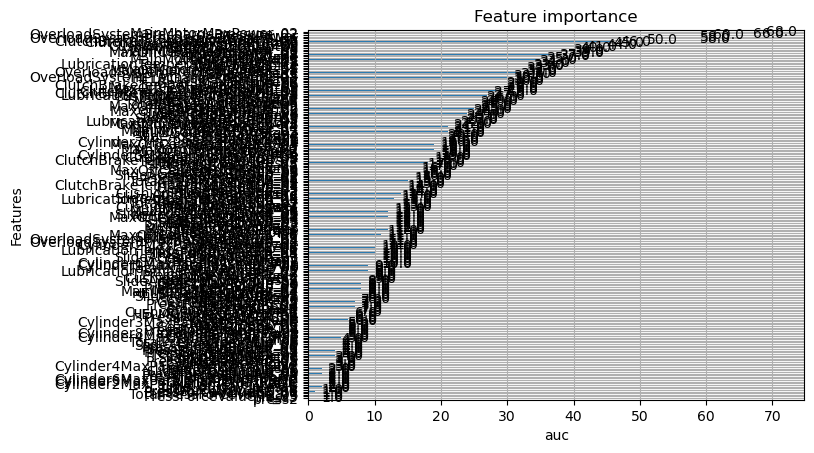

In [32]:
import matplotlib.pyplot as plt

ax = xgb.plot_importance(random_search.best_estimator_)
ax.set_xlabel('auc')  # Set the x-label to "auc"
plt.show()

<a id='3'>**Model Training**</a>

In [33]:
xgb_classifier = xgb.XGBClassifier(**best_params, random_state=42)
xgb_classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7001511164067925, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=91, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [34]:
# Getting the feature importances from the model
importance_dict = xgb_classifier.get_booster().get_score(importance_type='weight')

# Creating a DataFrame from the importances
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])

# Sorting the DataFrame by importance (descending order)
importance_df = importance_df.sort_values('Importance', ascending=False)

# Printing the table format
print(importance_df)

                                Feature  Importance
220                           MeanPower        94.0
222               AverageTemperatureOil        83.0
84   OverloadSystemPrechargePressure_02        63.0
199  OverloadSystemPrechargePressure_06        58.0
76                 MainMotorMaxPower_02        56.0
..                                  ...         ...
32     Cylinder5MaxParalelismErrorInBDC         1.0
6                    time_of_day_press4         1.0
175                PressForceValueRR_05         1.0
2                                press4         1.0
8                    time_of_day_press6         1.0

[224 rows x 2 columns]


<a id='4'>**Model Testing and Evaluation**</a>

In [37]:
y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC: {:.4f}".format(auc))

AUC: 0.9241
